In [1]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, model_from_json, load_model
from keras.layers import Dense, Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Attention, GlobalAveragePooling2D
import tensorflow as tf
from keras import backend as K

In [2]:
model = load_model('./trained_model.h5', compile=False)
# model.layers.pop(-1)

In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dense_1 (Dense)             (None, 124)               127100    
                                                                 
Total params: 3,696,828
Trainable params: 3,662,716
Non-trainable params: 34,112
_________________________________________________________________


In [4]:
new_model = tf.keras.models.Sequential(model.layers[:-1])

for layer in new_model.layers:
    layer.trainable = False

In [5]:
new_model.add(Dense(7, activation='softmax', name='output'))

In [6]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 output (Dense)              (None, 7)                 7175      
                                                                 
Total params: 3,576,903
Trainable params: 7,175
Non-trainable params: 3,569,728
_________________________________________________________________


In [7]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [8]:
new_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), f1_m])

In [9]:
train_data_dir = './fine_tune_dataset/train/'
test_data_dir = './fine_tune_dataset/test/'
img_height = 224
img_width = 224
batch_size = 4

In [10]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical',
    subset='training') # set as training data

val_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical',
    subset='validation') # set as validation data

test_generator = train_datagen.flow_from_directory(
    test_data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical') # set as validation data

Found 1350 images belonging to 7 classes.
Found 333 images belonging to 7 classes.
Found 7 images belonging to 7 classes.


In [11]:
history = new_model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = val_generator, 
    validation_steps = val_generator.samples // batch_size,
    epochs = 60)

Epoch 1/60
337/337 [==============================] - 10s 14ms/step - loss: 3.8676 - accuracy: 0.4368 - auc: 0.7539 - precision: 0.4422 - recall: 0.4324 - f1_m: 0.4356 - val_loss: 1.2019 - val_accuracy: 0.7590 - val_auc: 0.9218 - val_precision: 0.7599 - val_recall: 0.7530 - val_f1_m: 0.7569
Epoch 2/60
337/337 [==============================] - 4s 11ms/step - loss: 0.7235 - accuracy: 0.7994 - auc: 0.9597 - precision: 0.8078 - recall: 0.7897 - f1_m: 0.7958 - val_loss: 0.2659 - val_accuracy: 0.9066 - val_auc: 0.9920 - val_precision: 0.9283 - val_recall: 0.8976 - val_f1_m: 0.9015
Epoch 3/60
337/337 [==============================] - 3s 10ms/step - loss: 0.5400 - accuracy: 0.8210 - auc: 0.9757 - precision: 0.8360 - recall: 0.8068 - f1_m: 0.8138 - val_loss: 0.2215 - val_accuracy: 0.9187 - val_auc: 0.9964 - val_precision: 0.9321 - val_recall: 0.9096 - val_f1_m: 0.9135
Epoch 4/60
337/337 [==============================] - 3s 10ms/step - loss: 0.4125 - accuracy: 0.8759 - auc: 0.9832 - precision

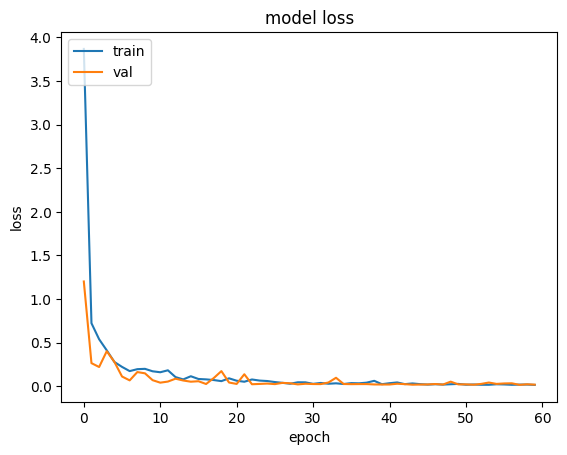

In [12]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

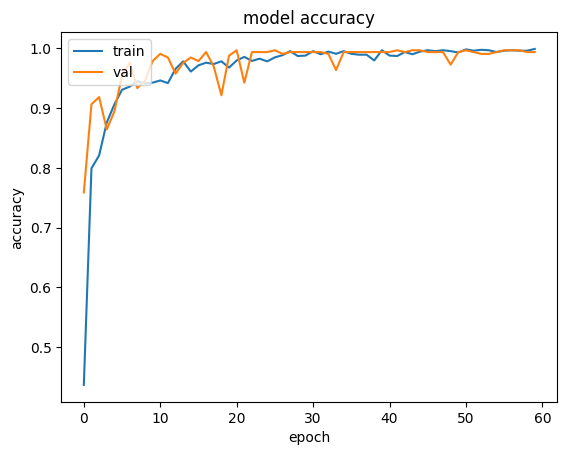

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

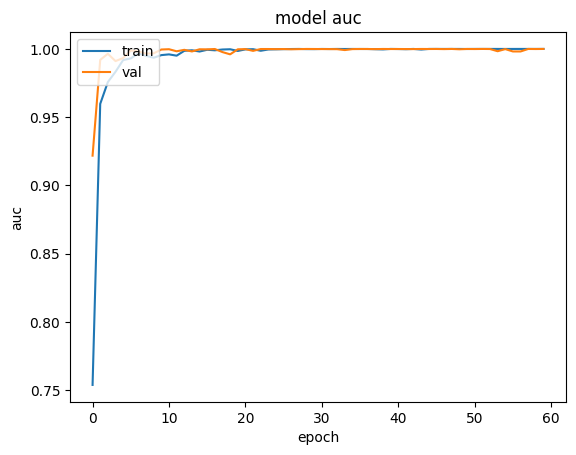

In [14]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

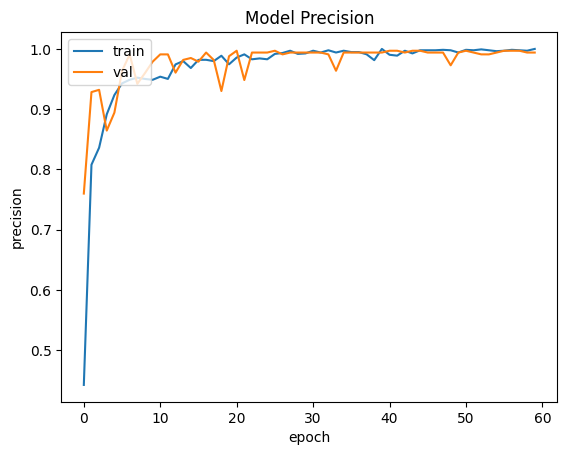

In [21]:
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model Precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

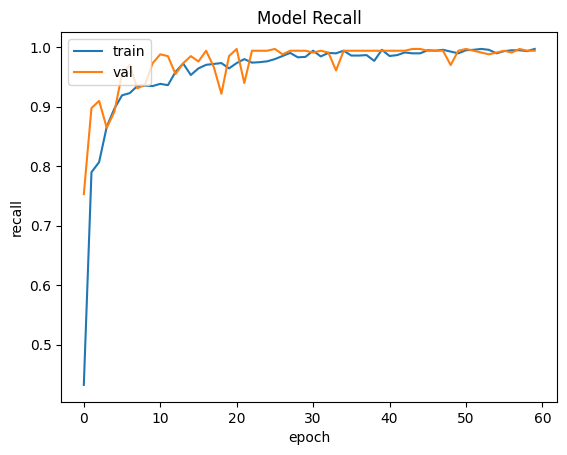

In [20]:
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model Recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

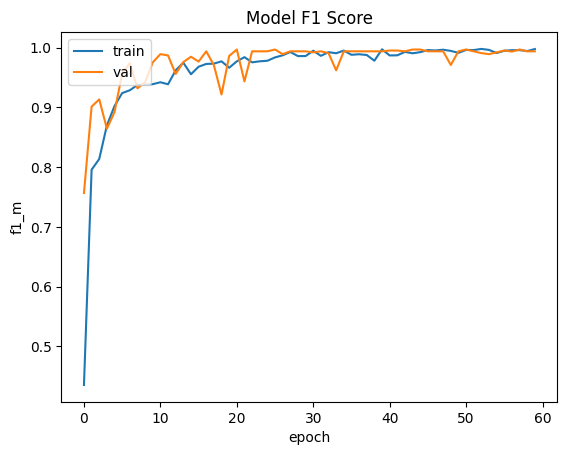

In [19]:
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('Model F1 Score')
plt.ylabel('f1_m')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [18]:
new_model.evaluate(test_generator)

2/2 [==============================] - 0s 58ms/step - loss: 8.7013e-04 - accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000 - f1_m: 1.0000


[0.0008701322367414832, 1.0, 1.0, 1.0, 1.0, 1.0]

In [14]:
import cv2

In [15]:
test_img = cv2.imread('./fine_tune_dataset/test/parthiv/parthiv_6.png')
test_img = cv2.resize(test_img, (224,224))
test_img = test_img/255

In [16]:
np.shape(test_img)

(224, 224, 3)

In [17]:
test_img = np.reshape(test_img, (1, 224, 224, 3))

In [18]:
preds = new_model.predict(test_img)

1/1 [==============================] - 1s 670ms/step


In [21]:
preds.shape

(1, 7)

In [19]:
np.argmax(preds)

5

In [22]:
data = test_generator.class_indices

search_label = 0

In [23]:
data

{'abhirami': 0,
 'aswathy': 1,
 'ayana': 2,
 'lekshmi': 3,
 'nandana': 4,
 'parthiv': 5,
 'shilpa': 6}

In [97]:
new_model.save('fine_tuned.h5')